In [1]:
import pandas as pd
import plotly.express as px

In [2]:
df = pd.read_csv('timeseries/netflix.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Period'] = [pd.to_datetime(x.strftime('%Y-%m-01')) for x in df['Date']]

In [5]:
ts = df.groupby('Period').mean()['Open']

In [6]:
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose

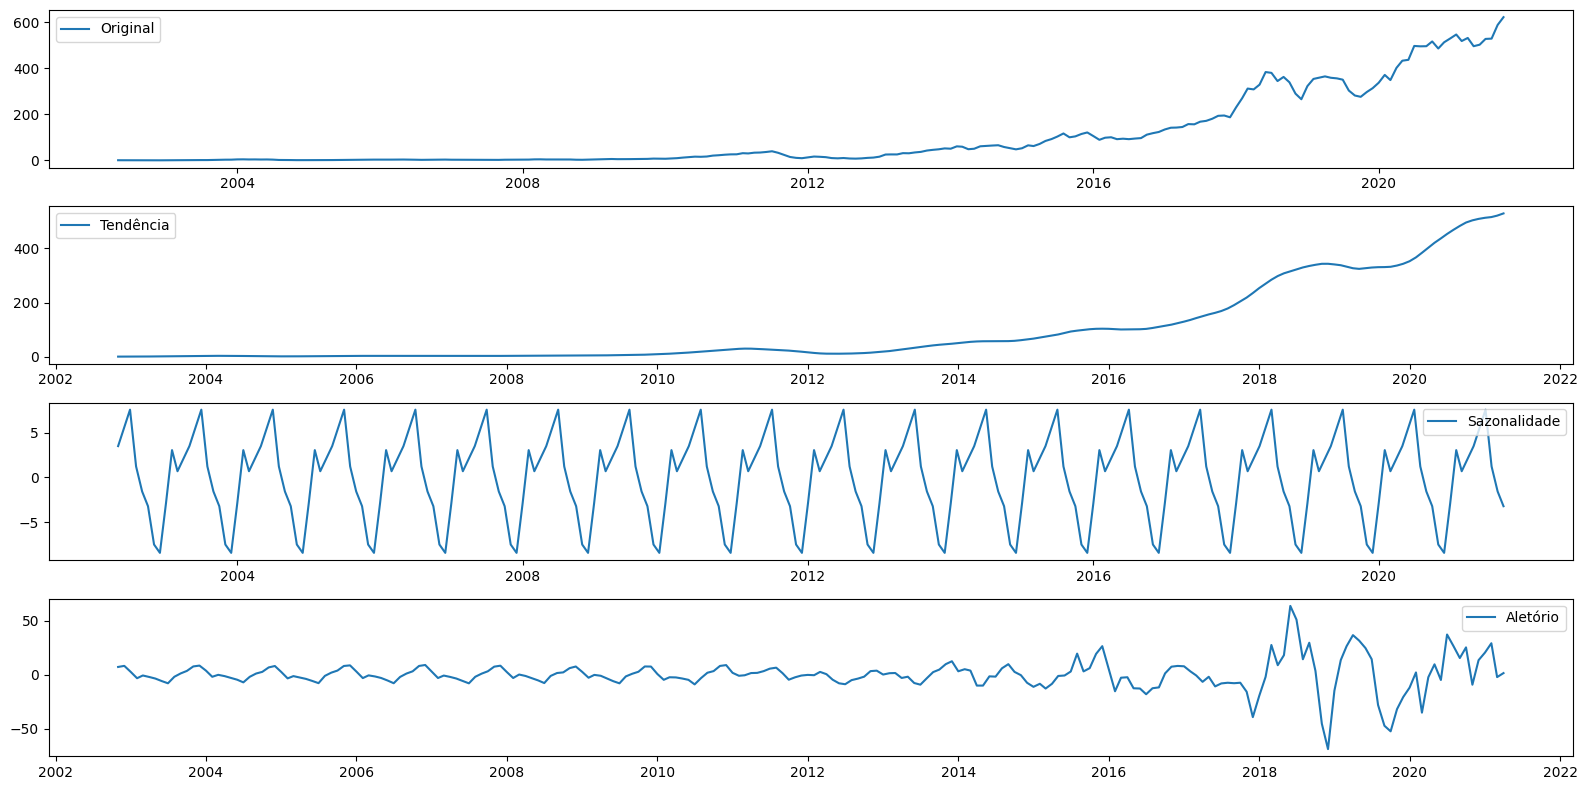

In [9]:
# Decomposição da série temporal, criando uma variável para cada formato
decomposicao = seasonal_decompose(ts)

plt.figure(figsize=(16,8))
plt.subplot(4,1,1)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')

# Visualização somente da tendência
plt.subplot(4,1,2)
plt.plot(decomposicao.trend, label = 'Tendência')
plt.legend(loc = 'best')

# Visualização somente da sazonalidade
plt.subplot(4,1,3)
plt.plot(decomposicao.seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')

# Visualização somente do elemento aleatório
plt.subplot(4,1,4)
plt.plot(decomposicao.resid, label = 'Aletório')
plt.legend(loc = 'best')
plt.tight_layout()

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [12]:
# Splitting the dataframe, last 12 months for test
train = ts[:-12]
test = ts[-12:]

modelo_auto = auto_arima(train, m = 12, seasonal = True, trace = False)
# modelo_auto.summary()

In [13]:
# Last 3 years of data
test = ts[-36:].reset_index()
test['Class'] = 'Real'

# Predicted data and boundaries
y_pred, conf_int = modelo_auto.predict(n_periods=24, return_conf_int=True, alpha=0.05)
y_pred.name = 'Predicted'
pred = pd.DataFrame(data=conf_int, index=y_pred.index, columns=['LI','LS'])\
    .join(y_pred, on = None, how='inner', validate='1:1').reset_index(names='Period')\
    .melt(id_vars='Period',var_name='Class', value_name='Open')
test_plot = pd.concat([test,pred], ignore_index=True).sort_values(by='Period')

In [14]:
px.line(test_plot, x='Period', y='Open', color='Class', title='Volume x Period')

c:\Users\paulo\AppData\Local\Programs\Python\Python39\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [ ]:
plt.figure(figsize=(16,8))
plt.plot()


In [88]:
# Last 3 years of data
test = ts[-36:].reset_index()

# Predicted data and boundaries
y_pred, conf_int = modelo_auto.predict(n_periods=24, return_conf_int=True, alpha=0.05)
y_pred.name = 'Predicted'
pred = pd.DataFrame(data=conf_int, index=y_pred.index, columns=['LI','LS'])\
    .join(y_pred, on = None, how='inner', validate='1:1').reset_index(names='Period')
test_plot = test.merge(pred, on = 'Period', how='outer')#.set_index('Period')
test_plot.loc[test_plot['Period'] == train.index.max(), :] = \
    test_plot.loc[test_plot['Period'] == train.index.max(), :]\
    .fillna(test_plot[test_plot['Period'] == train.index.max()]['Open'].max())
test_plot.set_index('Period', inplace=True)

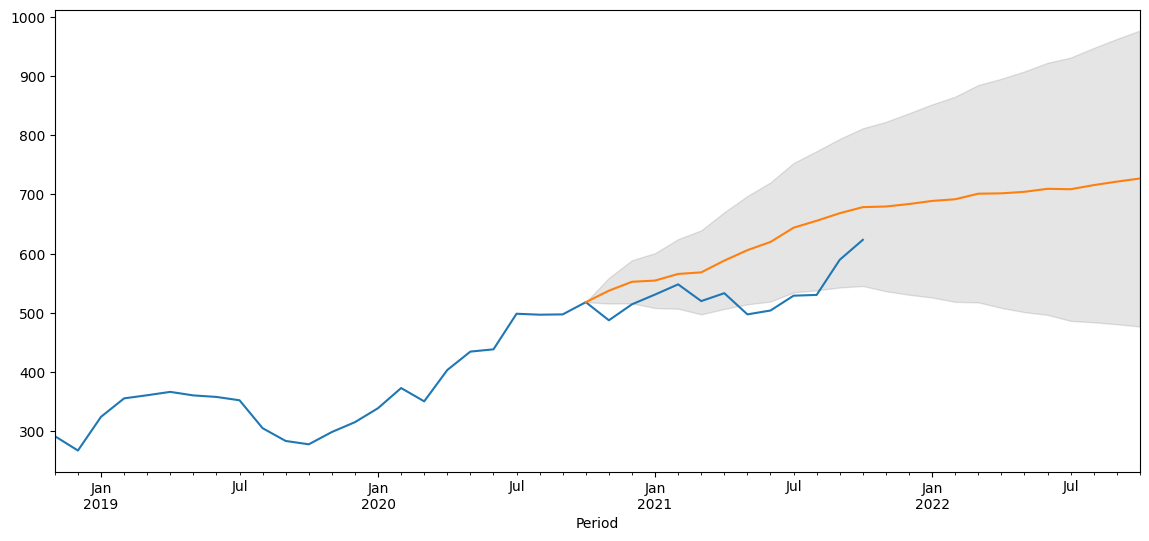

In [89]:
ax = test_plot['Open'].plot(label='Real', figsize=(14,6))
test_plot['Predicted'].plot(label='Predicted', ax=ax)
ax.fill_between(x=test_plot.index, y1=test_plot['LI'], y2=test_plot['LS'], color='k', alpha=.1)